## 9.7 ARIMA modelling in `statsforecast`
In the book the authors talk about ARIMA modelling in the R `fable` package. This does not exist in `statsmodels`, but a similar `AutoARIMA` model exist in the `statsforecast` library. In this notebook we walk through the `AutoARIMA` model using the tutorial on the website. https://nixtlaverse.nixtla.io/statsforecast/docs/models/autoarima.html

### What is AutoARIMA with StatsForecast? 
An autoARIMA is a time series model that uses an automatic process to select the optimal ARIMA (Autoregressive Integrated Moving Average) model parameters for a given time series. ARIMA is a widely used statistical model for modeling and predicting time series.

The process of automatic parameter selection in an autoARIMA model is performed using statistical and optimization techniques, such as the Akaike Information Criterion (AIC) and cross-validation, to identify optimal values for autoregression, integration, and moving average parameters. of the ARIMA model.

Automatic parameter selection is useful because it can be difficult to determine the optimal parameters of an ARIMA model for a given time series without a thorough understanding of the underlying stochastic process that generates the time series. The autoARIMA model automates the parameter selection process and can provide a fast and effective solution for time series modeling and forecasting.

The `statsforecast.models` library brings the `AutoARIMA` function from Python provides an implementation of autoARIMA that allows to automatically select the optimal parameters for an ARIMA model given a time series.

In [1]:
import sys
sys.path.append('..')
from utils import *

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/Naren8520/Serie-de-tiempo-con-Machine-Learning/main/Data/candy_production.csv")
df.head()

,observation_date,IPG3113N
0,1972-01-01,85.6945
1,1972-02-01,71.8200
2,1972-03-01,66.0229
3,1972-04-01,64.5645
4,1972-05-01,65.0100


In [4]:
# Put it into the standard statsforecast dataframe format
df['unique_id'] = 1
df.columns = ['ds', 'y', 'unique_id']
df.head()

,ds,y,unique_id
0,1972-01-01,85.6945,1
1,1972-02-01,71.8200,1
2,1972-03-01,66.0229,1
3,1972-04-01,64.5645,1
4,1972-05-01,65.0100,1


In [5]:
df['ds'] = pd.to_datetime(df['ds'])

In [6]:
from statsforecast import StatsForecast

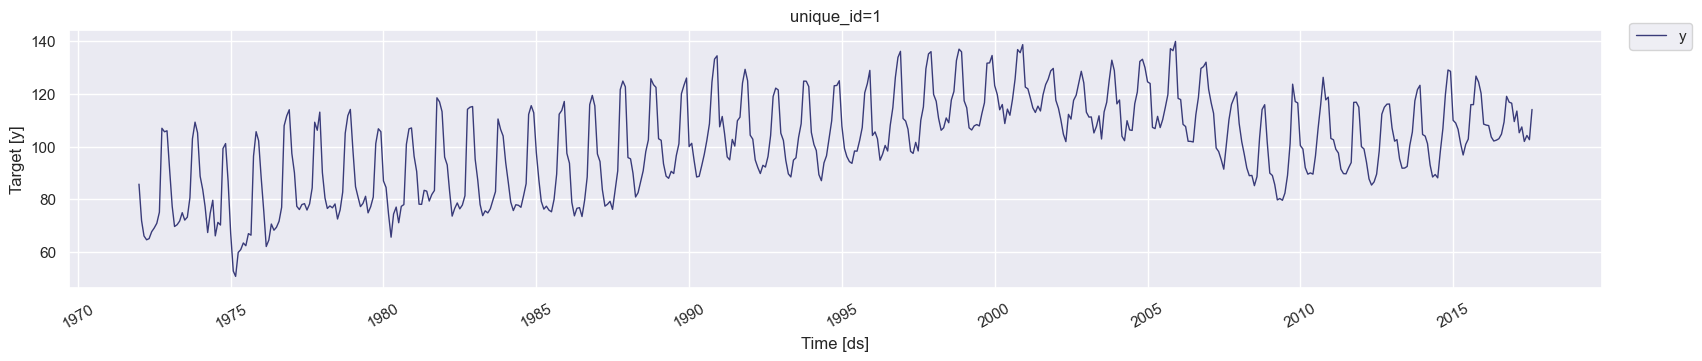

In [7]:
StatsForecast.plot(df)

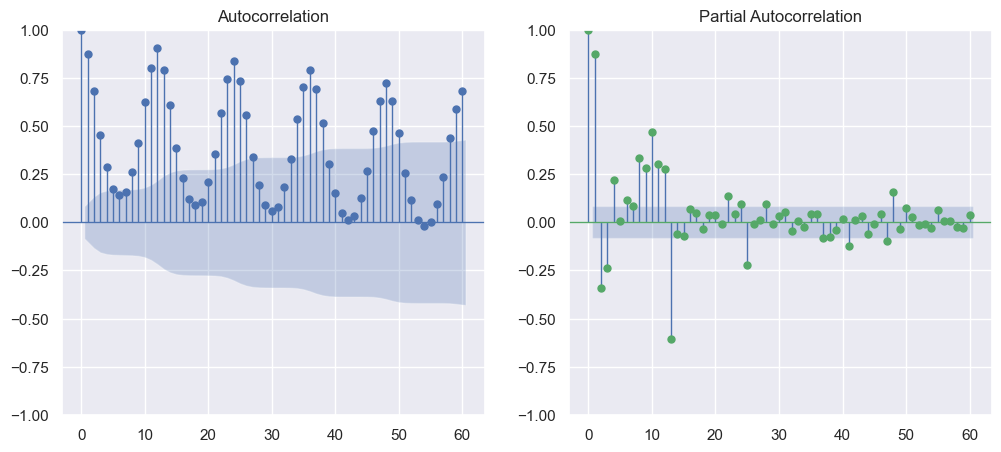

In [8]:
# Autocorrelation plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(df['y'], lags=60, ax=axes[0])
axes[0].set(title='Autocorrelation');

plot_pacf(df['y'], lags=60, ax=axes[1], color='g')
axes[1].set(title='Partial Autocorrelation')
plt.show();

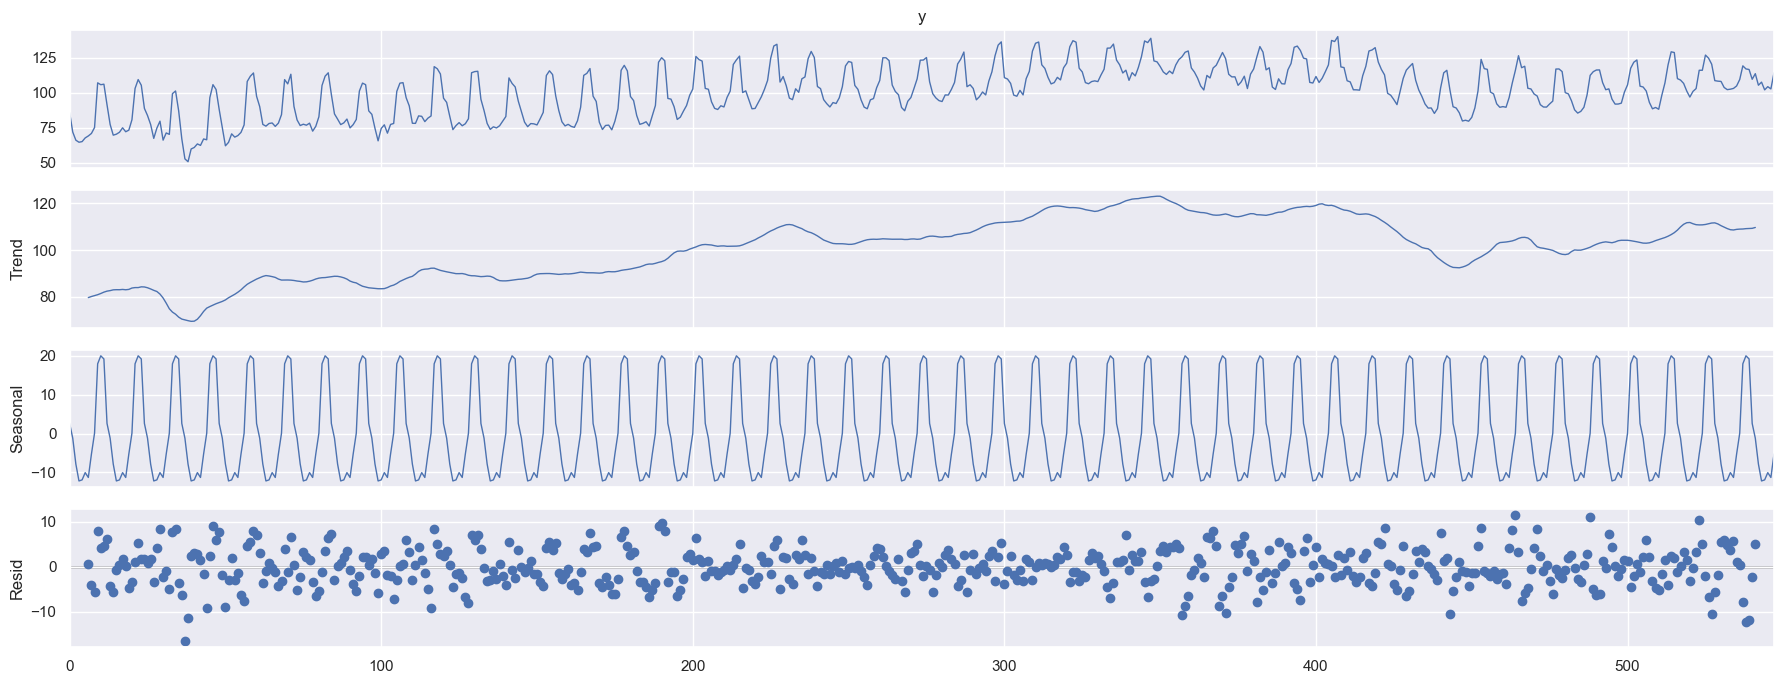

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
a = seasonal_decompose(df['y'], model='add', period=12)
a.plot();

### Split the data into training and testing
Train the `AutoArima` model. Use the last 12 months to test and evaluate the performance of the model.

In [10]:
Y_train_df = df[df['ds'] <= '2016-08-01']
Y_test_df = df[df['ds'] > '2016-08-01']

In [11]:
Y_train_df.shape, Y_test_df.shape

((536, 3), (12, 3))

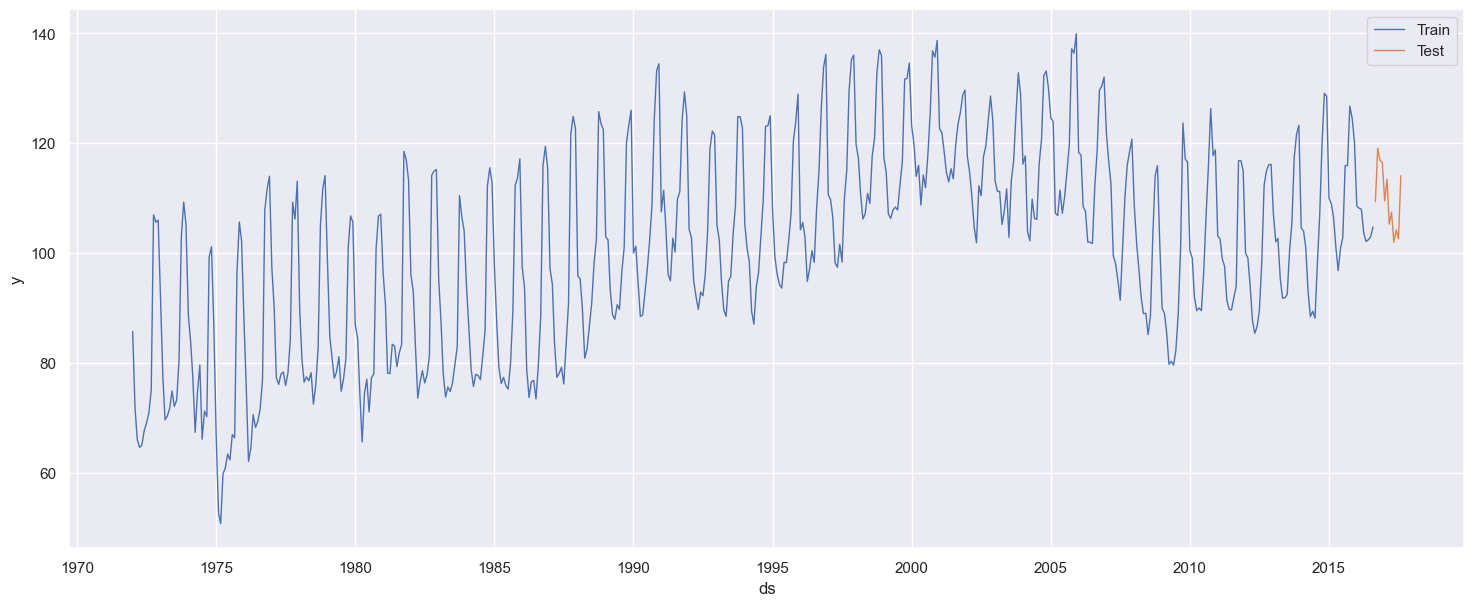

In [12]:
sns.lineplot(Y_train_df, x='ds', y='y', label='Train')
sns.lineplot(Y_test_df, x='ds', y='y', label='Test')
plt.show();

### Implementation of AutoArima with StatsForecast

In [13]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string

In [14]:
season_length = 12 # Monthly data
horizon = len(Y_test_df) # Number of predictions

models = [AutoARIMA(season_length=season_length)]

We fit the models by instantiating a new StatsForecast object with the following parameters:

models: a list of models. Select the models you want from models and import them.
- `freq`: a string indicating the frequency of the data (see Pandas's available frequencies)
- `n_jobs`: int, number of jobs used in the parallel processing, use -1 for all cores.
- `fallback_model`: a model to be used if a model fails.


In [15]:
sf = StatsForecast(df=Y_train_df, models=models, freq='MS', n_jobs=-1)

In [16]:
sf.fit()

StatsForecast(models=[AutoARIMA])

In [17]:
# We can use the `arima_string` function to see the parameters that the model has found.
arima_string(sf.fitted_[0, 0].model_)

'ARIMA(2,0,2)(0,1,2)[12]                   '

The automation process gave us that the best model found is a model of the form `ARIMA(2,0,2)(0,1,2)[12]`, this means that our model contains 
$p=2$, that is, it has two non-seasonal autogressive element, $q=2$, 2 non-seasonal moving average element; on the other hand, our model contains a seasonal part, which has an order of $D=1$, that is, it has a seasonal differential, and $q=2$ that contains 2 moving average element.

In [18]:
result = sf.fitted_[0, 0].model_
print(result.keys())
print(result['arma'])

dict_keys(['coef', 'sigma2', 'var_coef', 'mask', 'loglik', 'aic', 'arma', 'residuals', 'code', 'n_cond', 'nobs', 'model', 'bic', 'aicc', 'ic', 'xreg', 'x', 'lambda'])
(2, 2, 0, 2, 12, 0, 1)


In [19]:
residual = pd.DataFrame(result.get('residuals'), columns=['residual Model'])
residual

,residual Model
0,0.085694
1,0.071820
2,0.066022
3,0.064564
4,0.065009
...,...
531,2.781249
532,3.288113
533,0.247510
534,0.350248


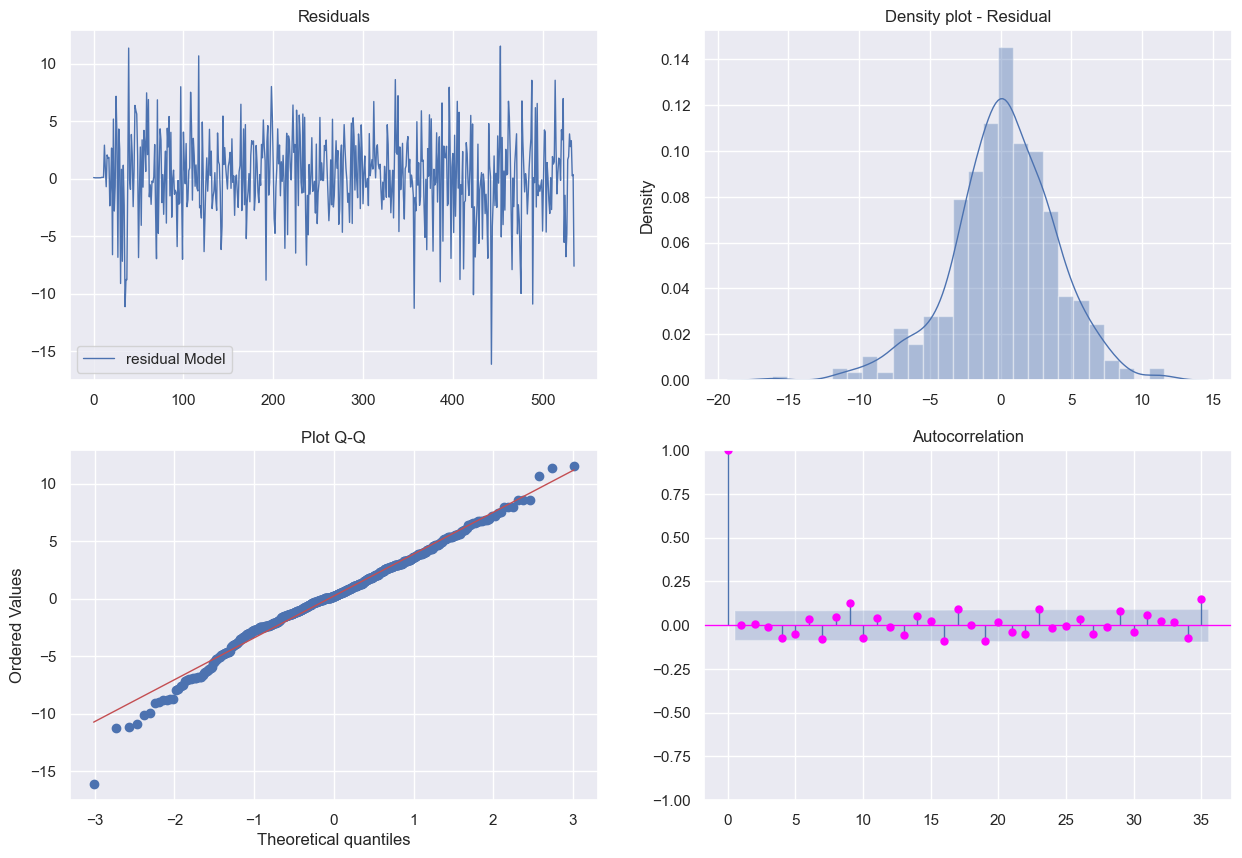

In [21]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# plot[1,1]
residual.plot(ax=axs[0,0])
axs[0,0].set_title("Residuals");

# plot
sns.distplot(residual, ax=axs[0,1]);
axs[0,1].set_title("Density plot - Residual");

# plot
stats.probplot(residual["residual Model"], dist="norm", plot=axs[1,0])
axs[1,0].set_title('Plot Q-Q')

# plot
plot_acf(residual,  lags=35, ax=axs[1,1],color="fuchsia")
axs[1,1].set_title("Autocorrelation");

plt.show();

To generate forecasts we only have to use the predict method specifying the forecast horizon (h). In addition, to calculate prediction intervals associated to the forecasts, we can include the parameter level that receives a list of levels of the prediction intervals we want to build. In this case we will only calculate the 90% forecast interval (level=[90]).​

### Forecast Method
If you want to gain speed in productive settings where you have multiple series or models we recommend using the `StatsForecast.forecast` method instead of `.fit` and `.predict`.

The main difference is that the `.forecast` doesn't not store the fitted values and is highly scalable in distributed environments.

The forecast method takes two arguments: forecasts next `h` (horizon) and `level`.

- `h` (int): represents the forecast $h$ steps into the future. In this case, 12 months ahead.
- `level` (list of floats): this optional parameter is used for probabilistic forecasting. Set the level (or confidence percentile) of your prediction interval. For example, level=[90] means that the model expects the real value to be inside that interval 90% of the times.

In [34]:
Y_hat_df = sf.forecast(horizon, fitted=True)

In [26]:
values = sf.forecast_fitted_values()
values

,ds,y,AutoARIMA
unique_id,,,
1,1972-01-01,85.6945,85.608806
1,1972-02-01,71.8200,71.748180
1,1972-03-01,66.0229,65.956878
1,1972-04-01,64.5645,64.499936
1,1972-05-01,65.0100,64.944991
...,...,...,...
1,2016-04-01,103.6179,100.836651
1,2016-05-01,102.0816,98.793487
1,2016-06-01,102.4044,102.156890


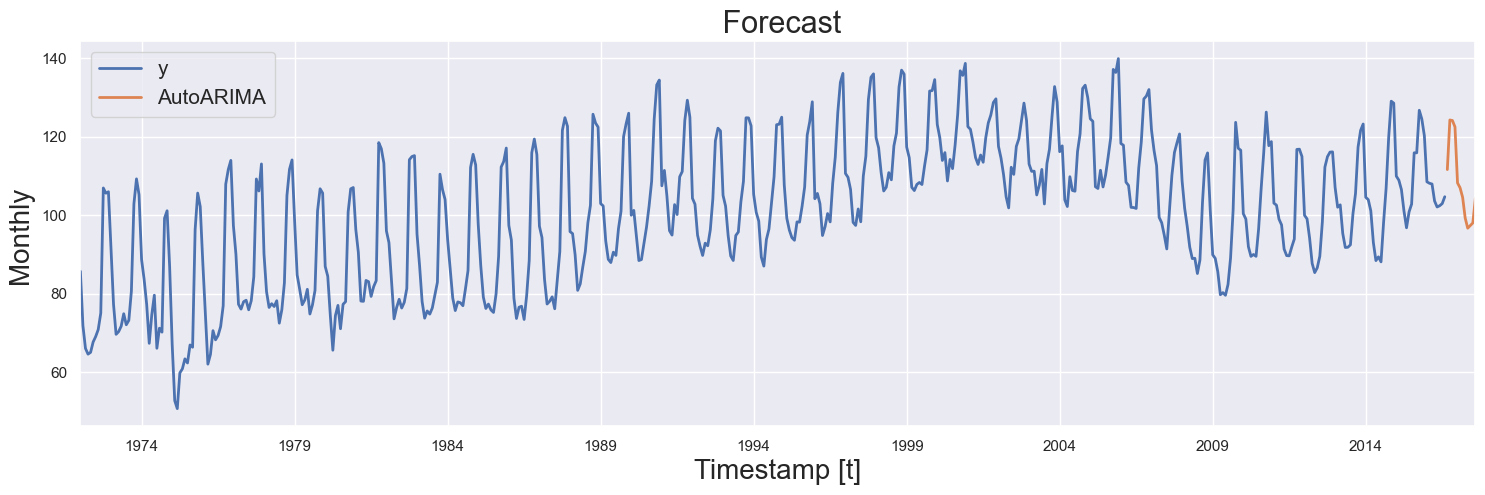

In [49]:
Y_test_df['unique_id'] = Y_test_df['unique_id'].astype(int)
Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])

fig, ax = plt.subplots(1, 1, figsize = (18, 5))
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')
plot_df[['y', 'AutoARIMA']].plot(ax=ax, linewidth=2)
ax.set_title(' Forecast', fontsize=22)
ax.set_ylabel('Monthly ', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})

### Predict method with confidence interval
To generate forecasts use the predict method.

The predict method takes two arguments: forecasts the next `h` (for horizon) and `level`.

- `h` (int): represents the forecast $h$ steps into the future. In this case, 12 months ahead.
- `level` (list of floats): this optional parameter is used for probabilistic forecasting. Set the level (or confidence percentile) of your prediction interval. For example, level=[95] means that the model expects the real value to be inside that interval 95% of the times.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals.

In [41]:
forecast_df = sf.predict(h=12, level=[80, 95])
forecast_df

,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-lo-80,AutoARIMA-hi-80,AutoARIMA-hi-95
unique_id,,,,,,
1,2016-09-01,111.627517,104.328704,106.855080,116.399954,118.926330
1,2016-10-01,124.269795,115.388505,118.462632,130.076959,133.151086
1,2016-11-01,124.133063,114.454857,117.804824,130.461302,133.811269
1,2016-12-01,122.504838,111.989695,115.629356,129.380321,133.019982
1,2017-01-01,108.224361,97.129666,100.969930,115.478792,119.319055
1,2017-02-01,106.978976,95.349954,99.375167,114.582785,118.607998
1,2017-03-01,104.554547,92.505816,96.676305,112.432788,116.603277
1,2017-04-01,99.295343,86.877101,91.175491,107.415196,111.713586
1,2017-05-01,96.681996,83.957646,88.361991,105.002002,109.406347


In [ ]:
df_plot = pd.concat([df, forecast_df]).set_index('ds').tail(220)

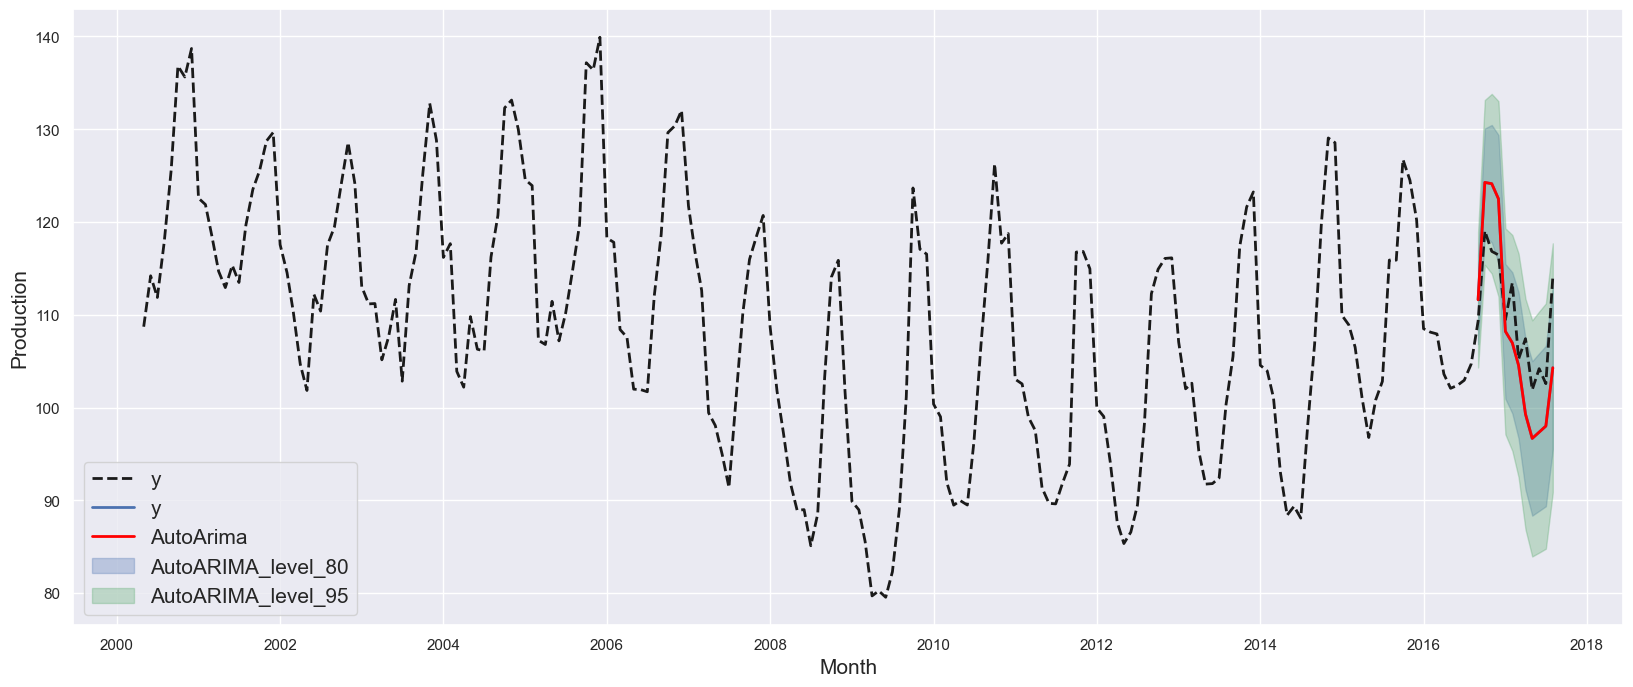

In [46]:
fig, ax = plt.subplots(1, 1, figsize = (20, 8))

plt.plot(df_plot['y'], 'k--', df_plot['AutoARIMA'], 'b-', linewidth=2 ,label="y")
plt.plot(df_plot['AutoARIMA'], 'b-',  color="red", linewidth=2, label="AutoArima")

# Specify graph features:
ax.fill_between(df_plot.index, 
                df_plot['AutoARIMA-lo-80'], 
                df_plot['AutoARIMA-hi-80'],
                alpha=.3,
                color='C0',
                label='AutoARIMA_level_80')
ax.fill_between(df_plot.index, 
                df_plot['AutoARIMA-lo-95'], 
                df_plot['AutoARIMA-hi-95'],
                alpha=.3,
                color='g',
                label='AutoARIMA_level_95')
ax.set_title('', fontsize=20)
ax.set_ylabel('Production', fontsize=15)
ax.set_xlabel('Month', fontsize=15)
ax.legend(prop={'size': 15})
ax.grid(True)
plt.show()

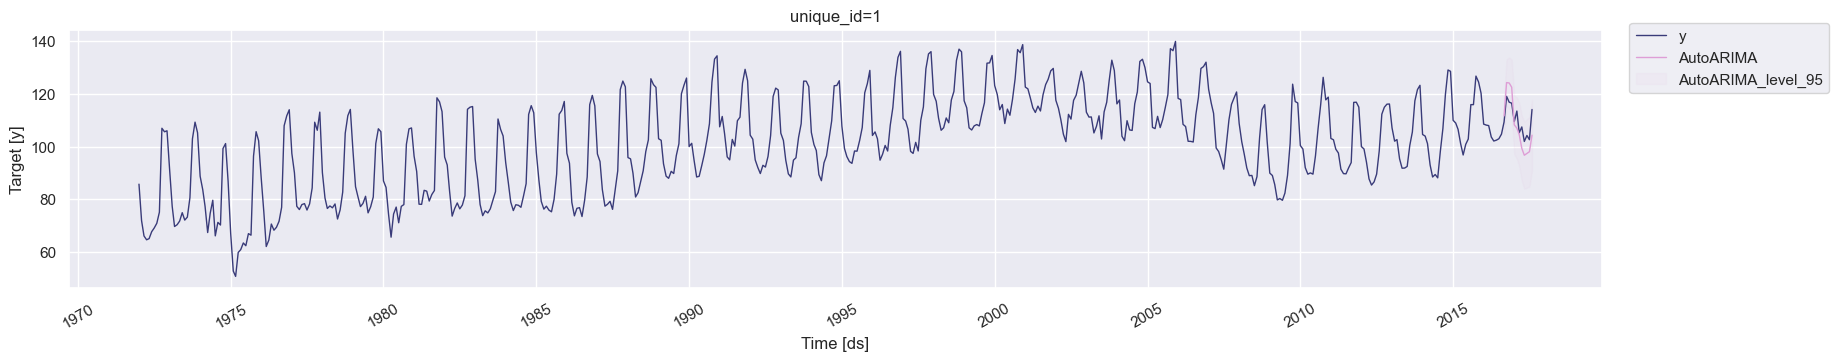

In [48]:
sf.plot(df, forecast_df, level=[95])

### Cross-validation
In previous steps, we’ve taken our historical data to predict the future. However, to asses its accuracy we would also like to know how the model would have performed in the past. To assess the accuracy and robustness of your models on your data perform Cross-Validation.

With time series data, Cross Validation is done by defining a sliding window across the historical data and predicting the period following it. This form of cross-validation allows us to arrive at a better estimation of our model’s predictive abilities across a wider range of temporal instances while also keeping the data in the training set contiguous as is required by our models.

#### Perform time series cross-validation
Cross-validation of time series models is considered a best practice but most implementations are very slow. The `statsforecast` library implements cross-validation as a distributed operation, making the process less time-consuming to perform. If you have big datasets you can also perform Cross Validation in a distributed cluster using Ray, Dask or Spark.

In this case, we want to evaluate the performance of each model for the last 5 months (`n_windows=5`), forecasting every second months (`step_size=12`). Depending on your computer, this step should take around 1 min.

The cross_validation method from the StatsForecast class takes the following arguments.
- `df`: training data frame
- `h` (int): represents h steps into the future that are being forecasted. In this case, 12 months ahead.
- `step_size` (int): step size between each window. In other words: how often do you want to run the forecasting processes.
- `n_windows` (int): number of windows used for cross validation. In other words: what number of forecasting processes in the past do you want to evaluate.

The crossvalidation_df object is a new data frame that includes the following columns:

- `unique_id`: index. If you don't like working with index just run `crossvalidation_df.reset_index()`
- `ds`: datestamp or temporal index
- `cutoff`: the last datestamp or temporal index for the n_windows.
- `y`: true value
- `"model"`: columns with the model’s name and fitted value.

In [50]:
crossvalidation_df = sf.cross_validation(df=Y_train_df,
                                         h=12,
                                         step_size=12,
                                         n_windows=5)

### Model Evaluation
We can now compute the accuracy of the forecast using an appropiate accuracy metric. Here we’ll use the Root Mean Squared Error (RMSE). To do this, we first need to install `datasetsforecast`, a Python library developed by Nixtla that includes a function to compute the RMSE.

In [60]:
from datasetsforecast.losses import mae, mape, mase, rmse, smape

In [54]:
rmse = rmse(crossvalidation_df['y'], crossvalidation_df["AutoARIMA"])
print("RMSE using cross-validation: ", rmse)

RMSE using cross-validation:  6.004913395330821


In [55]:
def evaluate_performace(y_hist, y_true, model):
    evaluation = {}
    evaluation[model] = {}
    for metric in [mase, mae, mape, rmse, smape]:
        metric_name = metric.__name__
        if metric_name == 'mase':
            evaluation[model][metric_name] = metric(y_true['y'].values, 
                                                y_true[model].values, 
                                                y_hist['y'].values, seasonality=12)
        else:
            evaluation[model][metric_name] = metric(y_true['y'].values, y_true[model].values)
    return pd.DataFrame(evaluation).T

In [58]:
Y_hat_df.drop(columns=['y_y'], inplace=True)
Y_hat_df.columns = ['ds', 'y', 'unique_id', 'AutoARIMA']

In [ ]:
evaluate_performace(Y_train_df, Y_hat_df, model='AutoARIMA')

,mase,mae,mape,rmse,smape
AutoARIMA,1.026517,5.318124,4.80942,5.937447,4.882829
